In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy
import sys
from matplotlib.path import Path
import emcee
import corner
from gencmd.model import SSP

# Step 1. Get the SMASH data

In [2]:
def read_fits (name):
    hdulist = fits.open(name)
    field_data = hdulist[1].data
    header = hdulist[1].header
    hdulist.close()
    return field_data

In [3]:
# Function that dereddenes a set of magnitudes. It uses the standard method and the user has to decide which coefficients wants to use.
# By default, it uses the filters of DECam
def dereddener(mag, filter_index, EBV, field_number = 9, filterset = 'decam'):
    
    if field_number == '5' or field_number == '6' or field_number == '9' or field_number == '10' or field_number == '11':
        EBV[np.where(EBV > 0.3)] = 0.037 #This line is to ensure we don't have unrealistic extinction values in the SMC centre. The limit is debatable.
    if filterset == 'decam':
        return mag - extinction_coeff_decam[filter_index]*EBV
    else:
        return mag - extinction_coeff_sdss[filter_index]*EBV

In [72]:
xbinsize = 0.005
ybinsize = 0.015
xbins = np.arange( start = -1, stop = 2, step = xbinsize)
ybins = np.arange( start = 14, stop = 24, step = ybinsize)

# Respectively u,g,r,i,z. Ex: u0 = u - 4.239*E(B-V)
extinction_coeff_sdss = np.array([4.239, 3.303, 2.285, 1.698, 1.263])
# Respectively u,g,r,i,z,Y. Ex: A_u = R_u*EBV_SFD98 ; u0 = u - A_u
extinction_coeff_decam = np.array([3.9631, 3.1863, 2.1401, 1.5690, 1.1957, 1.0476])

vertex_coord = [(0.75,23),(1,20.3),(0.5,20),(0.5,20.5),(0.3,20.5),(0.75,23)]
vertex_coord_2 = [(0.815,22.3),(0.92,21.5),(0.5,20),(0.43,19.5),(0.3,19.5),(0.4,20.5)]

In [5]:
smash_data = read_fits('/home/pol/PhD_DATA/SMASH_DATA/Field9_allobj_stars.fits.gz')

In [6]:
mag_g = dereddener(smash_data['G'], 1, smash_data['EBV'])
mag_i = dereddener(smash_data['I'], 3, smash_data['EBV'])

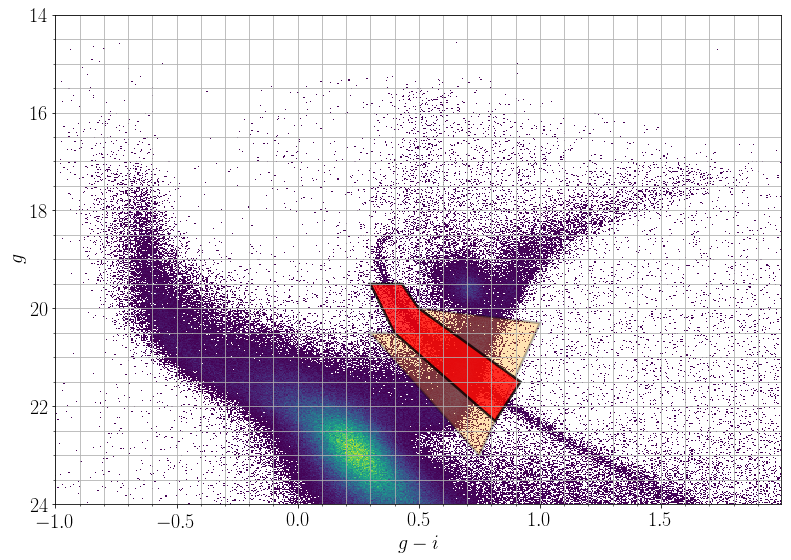

In [73]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':20})
fig = plt.figure(1, figsize=(13,9))
ax = fig.add_subplot(111)

ax.hist2d(mag_g - mag_i, mag_g, bins = [xbins, ybins], cmin = 1)
vertex_list = [list(x) for x in vertex_coord]
vertex_array = np.array(vertex_list)
polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.3, edgecolor = 'black', facecolor = 'orange', linestyle = '-', linewidth = '2.5')
ax.add_patch(polygon)
vertex_list = [list(x) for x in vertex_coord_2]
vertex_array = np.array(vertex_list)
polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.8, edgecolor = 'black', facecolor = 'red', linestyle = '-', linewidth = '2.5')
ax.add_patch(polygon)
ax.set_xlabel('$g-i$')
ax.set_ylabel('$g$')
#plt.colorbar()
plt.gca().invert_yaxis()
plt.minorticks_on()
plt.grid(which = 'both')
plt.show()

In [74]:
path = Path(vertex_coord_2)
mask_bool = path.contains_points(np.stack((mag_g-mag_i, mag_g)).T)
print mask_bool.shape, mag_g.shape

(856623,) (856623,)


In [75]:
# Let's get an isochrone over here to model the MS in this area.

isochrones_data = np.loadtxt('/home/pol/Documents/PhD/CMD_SMASH/Isochrones/NGC362_final_isochrone.cmd')

distance_modulus = 14.67
g_i_isochrone = isochrones_data[:,10] - isochrones_data[:,12]
g_isochrone = isochrones_data[:,10]
isochrone_mask = path.contains_points(np.stack((g_i_isochrone, g_isochrone+distance_modulus)).T)
print g_i_isochrone[isochrone_mask]

[0.856379 0.835909 0.797052 0.775696 0.733663 0.724785 0.685681 0.681949
 0.650693 0.623153 0.622992 0.622761 0.622528 0.622297 0.599454 0.599242
 0.599032 0.578269 0.578076 0.574263 0.558972 0.558796 0.552058 0.541323
 0.541163 0.532045 0.525144 0.519454 0.510419 0.50935  0.501895 0.496674
 0.491763 0.48407  0.479498 0.472379 0.468197 0.461596 0.457684 0.451548
 0.447881 0.442169 0.438725 0.433387 0.430142 0.42272  0.422087 0.414585
 0.411751 0.407458 0.401424 0.40075  0.394496 0.389221 0.388545 0.383615
 0.378378 0.376412 0.373389 0.368734 0.366969 0.363259 0.360177 0.356301
 0.354443]


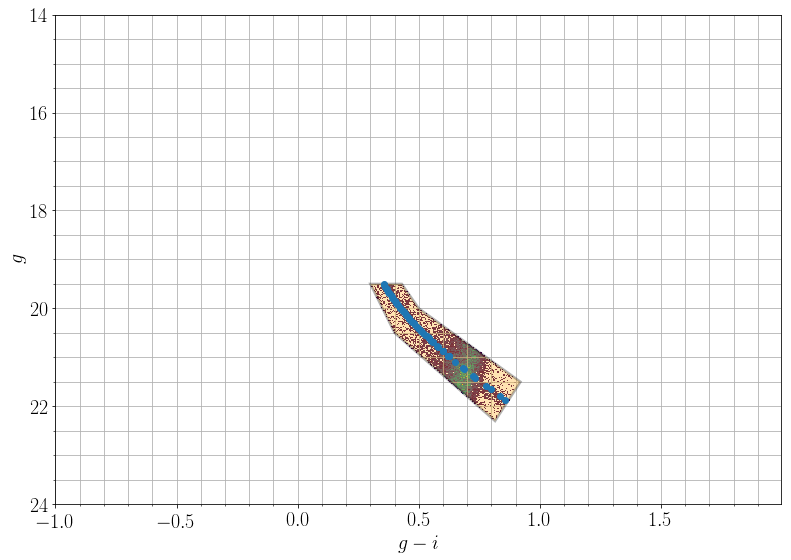

In [76]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':20})
fig = plt.figure(1, figsize=(13,9))
ax = fig.add_subplot(111)

slope = 2.0/0.46
intercept = 18.2
#ax.plot(xbins, slope*xbins+intercept)

ax.scatter(g_i_isochrone[isochrone_mask], g_isochrone[isochrone_mask]+distance_modulus, zorder = 10)

ax.hist2d(mag_g[mask_bool] - mag_i[mask_bool], mag_g[mask_bool], bins = [xbins, ybins], cmin = 1, zorder = 1)
vertex_list = [list(x) for x in vertex_coord_2]
vertex_array = np.array(vertex_list)
polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.3, edgecolor = 'black', facecolor = 'orange', linestyle = '-', linewidth = '2.5', zorder = 2)
ax.add_patch(polygon)
ax.set_xlabel('$g-i$')
ax.set_ylabel('$g$')
plt.gca().invert_yaxis()
plt.minorticks_on()
plt.grid(which='both')
plt.show()

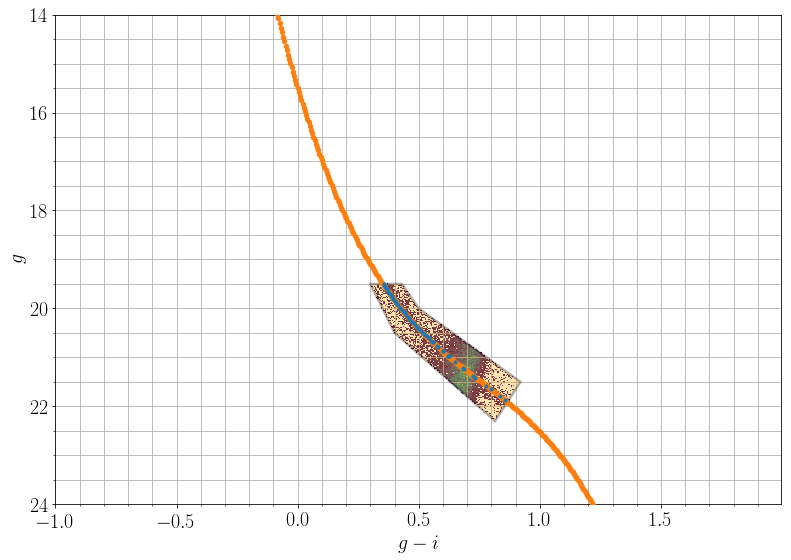

In [85]:
# Now we want to do a polynomical fit to these isochrone points
fit = np.polyfit(g_i_isochrone[isochrone_mask], g_isochrone[isochrone_mask]+distance_modulus, deg=3)
funcio = np.poly1d(fit)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':20})
fig = plt.figure(1, figsize=(13,9))
ax = fig.add_subplot(111)

ax.scatter(g_i_isochrone[isochrone_mask], g_isochrone[isochrone_mask]+distance_modulus, s=10, zorder = 4)
ax.scatter(xbins, funcio(xbins), zorder = 3, s=20)

ax.hist2d(mag_g[mask_bool] - mag_i[mask_bool], mag_g[mask_bool], bins = [xbins, ybins], cmin = 1, zorder = 1)
vertex_list = [list(x) for x in vertex_coord_2]
vertex_array = np.array(vertex_list)
polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.3, edgecolor = 'black', facecolor = 'orange', linestyle = '-', linewidth = '2.5', zorder = 2)
ax.add_patch(polygon)
ax.set_xlabel('$g-i$')
ax.set_ylabel('$g$')
plt.gca().invert_yaxis()
plt.minorticks_on()
plt.grid(which='both')
plt.show()

Right, now we want to take the probability that stars belong to the cluster by taking into account the distance to the isochrone and the distance to the cluster centre.

In [124]:
#functions to find distance from object to isochrone
def distance(p1,p2):
    dist=np.sqrt((p2[0]-p1[0])**2+(p2[1]-p1[1])**2)
    return dist

def closest(pt,others):
    return min(others,key=lambda i:distance(pt,i))

#function to determine probability of membership based on proximity to isochrone
def prob_memb_tuc(smash_gi, smash_i, sky_distance, iso_2d_array, sigma_c, sigma_m, eff_radius):
    prob_membership= np.array([]) 
    for i in range(0,len(smash_gi)):
        star_coords=[smash_gi[i],smash_i[i]]
        iso_coords=closest(star_coords,iso_2d_array)
        delta_gi=((star_coords[0]-iso_coords[0])**2)/(2*sigma_c)
        delta_i=((star_coords[1]-iso_coords[1])**2)/(2*sigma_m)
        delta_distance = sky_distance[i]**2 / (2 * eff_radius**2)
        prob_membership = np.append(prob_membership, np.exp(-delta_gi-delta_i - delta_distance))
    return prob_membership


#function to determine probability of membership based on proximity to isochrone
#def prob_memb_tuc(smash_gi, smash_i, sky_distance, iso_2d_array, sigma_c, sigma_m, eff_radius):
#    star_coords = np.vstack((smash_gi,smash_i))
#    iso_coords=closest(star_coords,iso_2d_array)
#    delta_gi=((star_coords[0]-iso_coords[0])**2)/(2*sigma_c)
#    delta_i=((star_coords[1]-iso_coords[1])**2)/(2*sigma_m)
#    delta_distance = sky_distance**2 / (2 * eff_radius**2)
#    prob_membership = np.exp(- delta_gi - delta_i - delta_distance)
#    return prob_membership

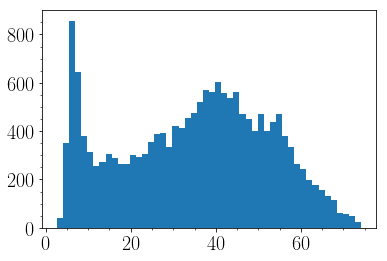

In [95]:
# For the membership probability we need the information abut the angular separation form the cluster centre.
cluster_centre = SkyCoord.from_name('NGC362')
stars_coordinates = SkyCoord(smash_data['RA'][mask_bool], smash_data['DEC'][mask_bool], unit = 'deg')
angular_separation = cluster_centre.separation(stars_coordinates).arcmin
plt.hist(angular_separation, bins = 50)
plt.minorticks_on()
plt.show()

In [177]:
iso_polyfit = np.stack((xbins, funcio(xbins))).T
iso_mask = path.contains_points(iso_polyfit)
print iso_polyfit[iso_mask].shape
sigma_c = 0.05
sigma_m = 0.3
eff_radius = 15.0 #arcmin
print mag_g[mask_bool].shape
membership_prob = prob_memb_tuc(mag_g[mask_bool] - mag_i[mask_bool], mag_g[mask_bool], angular_separation, iso_polyfit, sigma_c, sigma_m, eff_radius)
print membership_prob.shape

(103, 2)
(17567,)
(17567,)


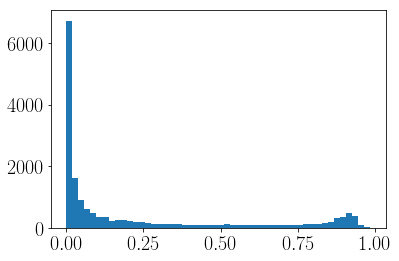

In [178]:
plt.hist(membership_prob, bins=50)
plt.show()

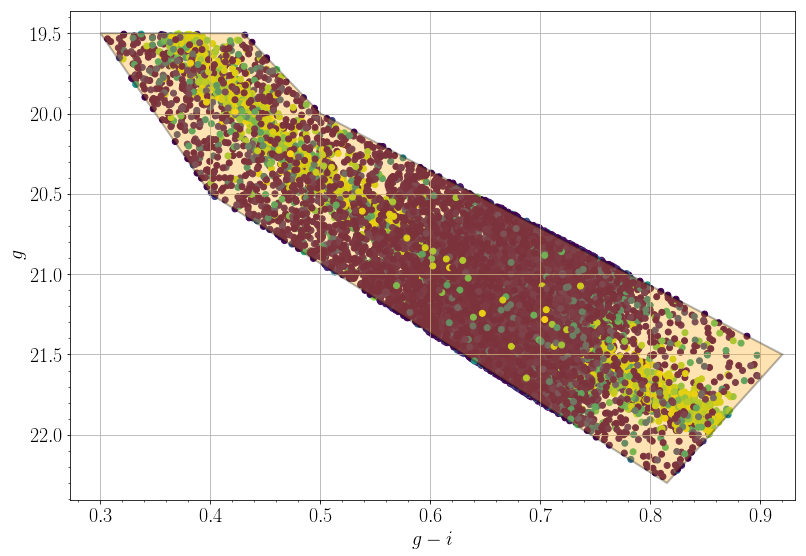

In [179]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':20})
fig = plt.figure(1, figsize=(13,9))
ax = fig.add_subplot(111)

#ax.scatter(g_i_isochrone[isochrone_mask], g_isochrone[isochrone_mask]+distance_modulus, s=10, zorder = 4)
#ax.scatter(xbins, funcio(xbins), zorder = 3, s=20)

ax.scatter(mag_g[mask_bool] - mag_i[mask_bool], mag_g[mask_bool], zorder = 1, c = membership_prob)
vertex_list = [list(x) for x in vertex_coord_2]
vertex_array = np.array(vertex_list)
polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.3, edgecolor = 'black', facecolor = 'orange', linestyle = '-', linewidth = '2', zorder = 2)
ax.add_patch(polygon)
ax.set_xlabel('$g-i$')
ax.set_ylabel('$g$')
plt.gca().invert_yaxis()
plt.minorticks_on()
plt.grid()
plt.show()

In [180]:
membership_mask = np.where(membership_prob > 0.5)
print mag_g[mask_bool][membership_mask].shape

(3736,)


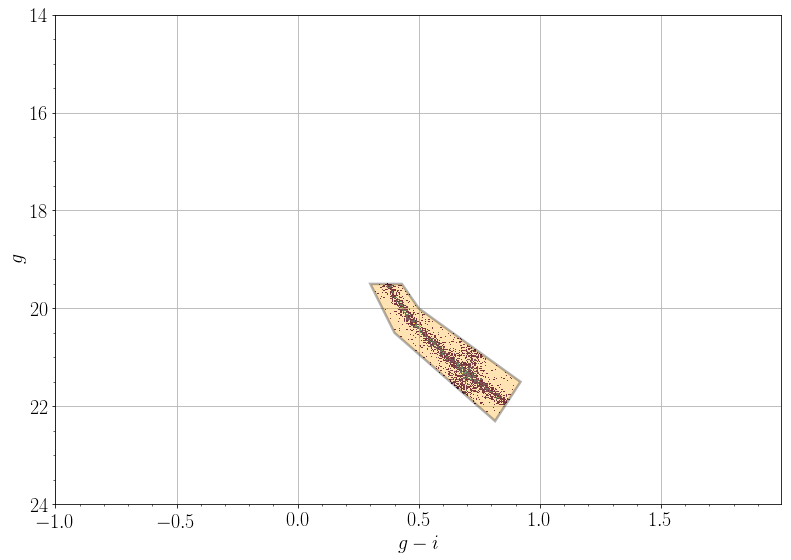

In [181]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':20})
fig = plt.figure(1, figsize=(13,9))
ax = fig.add_subplot(111)

ax.hist2d(mag_g[mask_bool][membership_mask] - mag_i[mask_bool][membership_mask], mag_g[mask_bool][membership_mask], bins = [xbins, ybins], cmin = 1, zorder = 1)
vertex_list = [list(x) for x in vertex_coord_2]
vertex_array = np.array(vertex_list)
polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.3, edgecolor = 'black', facecolor = 'orange', linestyle = '-', linewidth = '2.5', zorder = 2)
ax.add_patch(polygon)
ax.set_xlabel('$g-i$')
ax.set_ylabel('$g$')
plt.gca().invert_yaxis()
plt.minorticks_on()
plt.grid()
plt.show()

In [182]:
id_list = smash_data['ID'][mask_bool][membership_mask]
np.savetxt('/home/pol/Documents/PhD/CMD_SMASH/NGC362_stars.txt', id_list, fmt = '%s')
#final_cluster_stars_mask = np.where(smash_data['ID'][mask_bool][membership_mask])
#print final_cluster_stars_mask

(array([   0,    1,    2, ..., 3733, 3734, 3735]),)


TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

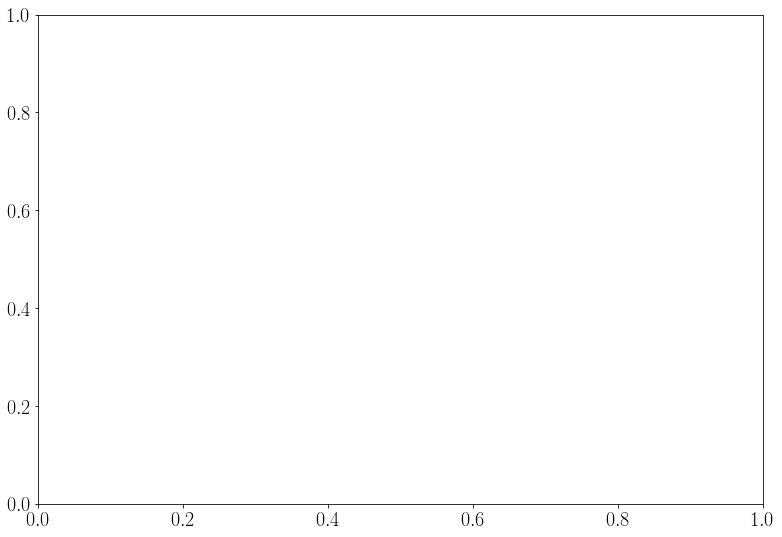

In [162]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':20})
fig = plt.figure(1, figsize=(13,9))
ax = fig.add_subplot(111)

colours = ~mag_g[mask_bool][membership_mask] - ~mag_i[mask_bool][membership_mask]
magnitudes = ~mag_g[mask_bool][membership_mask]

ax.hist2d(colours, magnitudes, bins = [xbins, ybins], cmin = 1, zorder = 1)
#vertex_list = [list(x) for x in vertex_coord_2]
#vertex_array = np.array(vertex_list)
#polygon = matplotlib.patches.Polygon(vertex_array, alpha = 0.3, edgecolor = 'black', facecolor = 'orange', linestyle = '-', linewidth = '2.5', zorder = 2)
#ax.add_patch(polygon)
ax.set_xlabel('$g-i$')
ax.set_ylabel('$g$')
plt.gca().invert_yaxis()
plt.minorticks_on()
plt.grid()
plt.show()